In [1]:
#import packages and libraries that assist with analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from pydataset import data

#stored functions and local credentials you will need to access the data
#stored in mysql or on you local device
import os
from acquire import get_telco_data
from prepare import prep_telco, prep_telco_encode, telco_train_validate_test_split
from env import host,db,protocol,password,user,mysqlcon
import acquire
from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer
import sklearn.metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

from sklearn.preprocessing import LabelEncoder

## Importing Dataset

* Aquire the data
  define your funtions or import stored functions
  verify your columns and rows
  get an overview of your data so you have an idea of what you're working with


In [2]:
#AQUIRE Your Data
#defined get_telco_data(): function here 
#but you can use get_telco data function from acquire.py to pull from mysqlworkbench 
#or a local file if you already have it on your machine

def get_telco_data():
    '''The function checks if you have the telco.csv file on your system already
    if so it pulls the data from there. If not it connects to the mysqlworkbench 
    using the connect sql queryand pulls the data from there. The data is then saved to 
    your machine as a .csv and the data is returned to the variable'''
    
    filenametelco = "telco.csv"
    mysqlcon=f"{protocol}://{user}:{password}@{host}/{db}"
    
    # if the file is already on you operating system the 
    #function will read the data from there. 
    if os.path.isfile(filenametelco):
        return pd.read_csv(filenametelco)
    else:
        #if not the data is pulled from the mysqlworkbench
        # read the SQL query into a dataframe
        df_telco_churn = pd.read_sql_query(
'''select * from customers
left join contract_types
using(contract_type_id)
left join internet_service_types
using (internet_service_type_id)
left join payment_types
using (payment_type_id)
left join customer_churn
using (customer_id);''', mysqlcon)

        # Write that dataframe to disk for later. Called "caching" the data for later.
        df_telco_churn.to_csv(filenametelco)

        # Return the dataframe to the calling code
        return df_telco_churn

In [3]:
#stored the telco data into a variable 
df = get_telco_data()

In [4]:
#verify rows and columns of the DataFrame.
df.shape

(7043, 25)

In [5]:
#quick check of your data to verify 
df.head()

,Unnamed: 0,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,0,2,1,2,0002-ORFBO,Female,0,Yes,Yes,9,...,Yes,Yes,No,Yes,65.6,593.3,No,One year,DSL,Mailed check
1,1,2,1,1,0003-MKNFE,Male,0,No,No,9,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
2,2,1,2,1,0004-TLHLJ,Male,0,No,No,4,...,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Fiber optic,Electronic check
3,3,1,2,1,0011-IGKFF,Male,1,Yes,No,13,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Fiber optic,Electronic check
4,4,2,2,1,0013-EXCHZ,Female,1,Yes,No,3,...,Yes,Yes,No,Yes,83.9,267.4,Yes,Month-to-month,Fiber optic,Mailed check


In [6]:
#drop missing values
df.dropna(inplace=True)


In [7]:
#Summary of column total with names, non null counts, and dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                7043 non-null   int64  
 1   payment_type_id           7043 non-null   int64  
 2   internet_service_type_id  7043 non-null   int64  
 3   contract_type_id          7043 non-null   int64  
 4   customer_id               7043 non-null   object 
 5   gender                    7043 non-null   object 
 6   senior_citizen            7043 non-null   int64  
 7   partner                   7043 non-null   object 
 8   dependents                7043 non-null   object 
 9   tenure                    7043 non-null   int64  
 10  phone_service             7043 non-null   object 
 11  multiple_lines            7043 non-null   object 
 12  online_security           7043 non-null   object 
 13  online_backup             7043 non-null   object 
 14  device_p

In [8]:
#Descriptive statistics(summary of your dataset)
df.describe()

,Unnamed: 0,payment_type_id,internet_service_type_id,contract_type_id,senior_citizen,tenure,monthly_charges
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,3521.000000,2.315633,1.872923,1.690473,0.162147,32.371149,64.761692
std,2033.283305,1.148907,0.737796,0.833755,0.368612,24.559481,30.090047
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,18.250000
25%,1760.500000,1.000000,1.000000,1.000000,0.000000,9.000000,35.500000
50%,3521.000000,2.000000,2.000000,1.000000,0.000000,29.000000,70.350000
75%,5281.500000,3.000000,2.000000,2.000000,0.000000,55.000000,89.850000
max,7042.000000,4.000000,3.000000,3.000000,1.000000,72.000000,118.750000


In [9]:
#check for column correlation to verify if any are the same or could represent the same unique value
#can possibly remove columns based on correlation. 
df.corr()

,Unnamed: 0,payment_type_id,internet_service_type_id,contract_type_id,senior_citizen,tenure,monthly_charges
Unnamed: 0,1.000000,0.004028,-0.012407,0.015028,-0.002074,0.008035,-0.003916
payment_type_id,0.004028,1.000000,0.008124,0.358913,-0.093704,0.340305,-0.074353
internet_service_type_id,-0.012407,0.008124,1.000000,0.099721,-0.032310,-0.030359,-0.323260
contract_type_id,0.015028,0.358913,0.099721,1.000000,-0.142554,0.671607,-0.074195
senior_citizen,-0.002074,-0.093704,-0.032310,-0.142554,1.000000,0.016567,0.220173
tenure,0.008035,0.340305,-0.030359,0.671607,0.016567,1.000000,0.247900
monthly_charges,-0.003916,-0.074353,-0.323260,-0.074195,0.220173,0.247900,1.000000


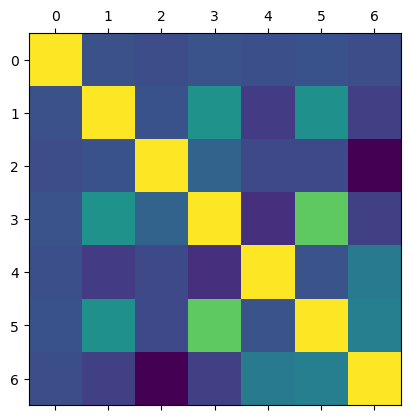

In [10]:
#matrix to show the correlation. 
plt.matshow(df.corr())

## Prepare the data 
* Split the data into X and y 
  X will hold the features
  y will hold the labels
  
* Drop any uneeded columns
  Encode feature columns for modeling
  Change datatypes to make data more uniform

In [11]:
#all object data types are assigned to variable X
#as a dataframe
#columns Unamed:0 and payment_type are dropped as uneeded columns
X=df.iloc[:,1:-1]


In [12]:
#verify the X variable is now a dataframe
#.head() gives a quick look at the data
X.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type
0,2,1,2,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,No,Yes,Yes,No,Yes,65.6,593.3,No,One year,DSL
1,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL
2,1,2,1,0004-TLHLJ,Male,0,No,No,4,Yes,...,Yes,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Fiber optic
3,1,2,1,0011-IGKFF,Male,1,Yes,No,13,Yes,...,Yes,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Fiber optic
4,2,2,1,0013-EXCHZ,Female,1,Yes,No,3,Yes,...,No,Yes,Yes,No,Yes,83.9,267.4,Yes,Month-to-month,Fiber optic


In [13]:
#'churn' is the target of our main analyis 
#so are y variable will hold the 'churn' variable
#from here we turn y into a dataframe like X 
y = df['churn']
y = pd.DataFrame(y)
y.head()

,churn
0,No
1,No
2,Yes
3,Yes
4,Yes


In [14]:
#y is turned into an array of 1s and 0s 
#representing churned or not churned
y=LabelEncoder().fit_transform(y)
y

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 0, 1, ..., 0, 0, 0])

In [15]:
def prep_telco_encode(X):
    
    '''defined prep_telco_encode(X) here but you can also call the function 
    using the prepart.py file. the function takes each column encodes the value 
    as a number representation and assigns it back to the column.'''
    #used LabelEncoder() and fit_transform() to create number
    #representations of the values.
    X['gender']=LabelEncoder().fit_transform(X['gender'])
    X['partner']=LabelEncoder().fit_transform(X['partner'])
    X['dependents']=LabelEncoder().fit_transform(X['dependents'])
    X['phone_service']=LabelEncoder().fit_transform(X['phone_service'])
    X['multiple_lines']=LabelEncoder().fit_transform(X['multiple_lines'])
    X['online_security']=LabelEncoder().fit_transform(X['online_security'])
    X['online_backup']=LabelEncoder().fit_transform(X['online_backup'])
    X['device_protection']=LabelEncoder().fit_transform(X['device_protection'])
    X['streaming_tv']=LabelEncoder().fit_transform(X['streaming_tv'])
    X['streaming_movies']=LabelEncoder().fit_transform(X['streaming_movies'])
    X['paperless_billing']=LabelEncoder().fit_transform(X['paperless_billing'])
    X['customer_id']=LabelEncoder().fit_transform(X['customer_id'])

    X['tech_support']=LabelEncoder().fit_transform(X['tech_support'])
    X['churn']=LabelEncoder().fit_transform(X['churn'])
    
    #converted monthly_charges to an int datatype to make the data more uniform
    X['monthly_charges'] = X['monthly_charges'].astype('int')
    
    #converted total_charges from an object to a number. 
    #if any errors, errors='coerce', is used so any value
    #that can't be converted to a number will be set to NaN(Not a Number)
    #Got the median of total_charges, median = X['total_charges'].median(), 
    #The median will be used to fill any NaN values using 
    #X['total_charges'].fillna(median,inplace=True)

    X['total_charges'] = pd.to_numeric(X['total_charges'],errors='coerce')
    median = X['total_charges'].median()
    X['total_charges'].fillna(median,inplace=True)
    
    #dropped uneeded columns other columns represent the same values
    X = X.drop(columns=['contract_type', 'internet_service_type', 'customer_id'])

    
    #once all of the above is finished the results will 
    #be store in the X variable 
    return X



In [16]:
#called prep_telco_encode() function to verify 
#that the changes were made to the data. 
prep_telco_encode(X)


,payment_type_id,internet_service_type_id,contract_type_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn
0,2,1,2,0,0,1,1,9,1,0,0,2,0,2,2,0,1,65,593.30,0
1,2,1,1,1,0,0,0,9,1,2,0,0,0,0,0,2,0,59,542.40,0
2,1,2,1,1,0,0,0,4,1,0,0,0,2,0,0,0,1,73,280.85,1
3,1,2,1,1,1,1,0,13,1,0,0,2,2,0,2,2,1,98,1237.85,1
4,2,2,1,0,1,1,0,3,1,0,0,0,0,2,2,0,1,83,267.40,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2,1,2,0,0,0,0,13,1,0,2,0,0,2,0,0,0,55,742.90,0
7039,1,2,1,1,0,1,0,22,1,2,0,0,0,0,0,2,1,85,1873.70,1
7040,2,1,1,1,0,0,0,2,1,0,0,2,0,0,0,0,1,50,92.75,0
7041,2,1,3,1,0,1,1,67,1,0,2,0,2,2,0,2,0,67,4627.65,0


In [17]:
#assigned the function with changes to 
#the X variable
X = prep_telco_encode(X)

In [18]:
#verify all dtypes in X are now numbers
#and columns are dropped. 
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   gender                    7043 non-null   int64  
 4   senior_citizen            7043 non-null   int64  
 5   partner                   7043 non-null   int64  
 6   dependents                7043 non-null   int64  
 7   tenure                    7043 non-null   int64  
 8   phone_service             7043 non-null   int64  
 9   multiple_lines            7043 non-null   int64  
 10  online_security           7043 non-null   int64  
 11  online_backup             7043 non-null   int64  
 12  device_protection         7043 non-null   int64  
 13  tech_support              7043 non-null   int64  
 14  streamin

## Highview early thinking
* With the below graphs we can get an overview breakdown of the data 
  We can check for key data related to each feature 
  Which could possibly help us deep dive into more specific areas

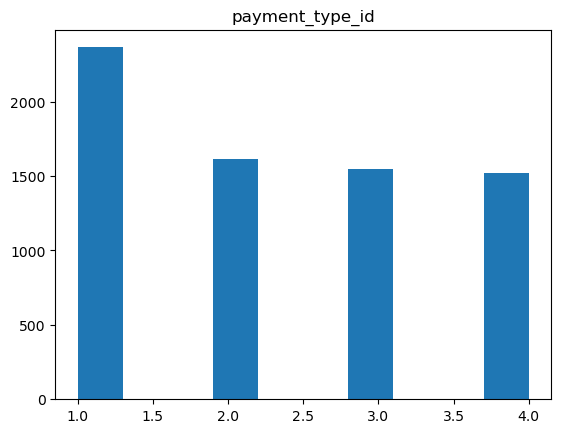

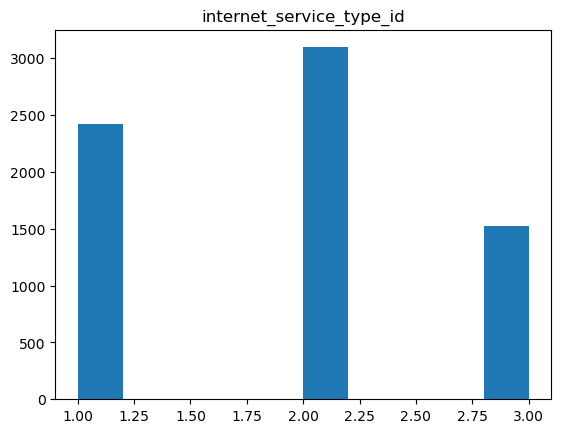

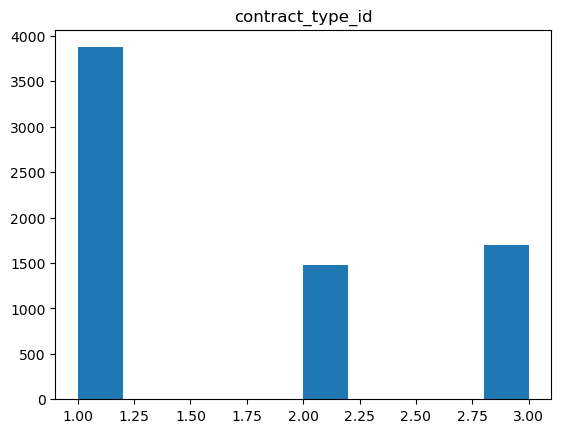

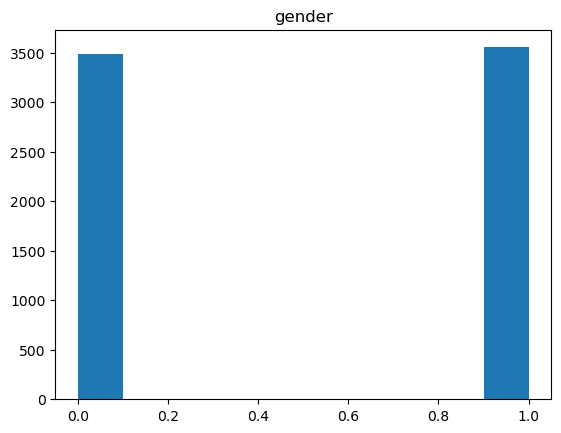

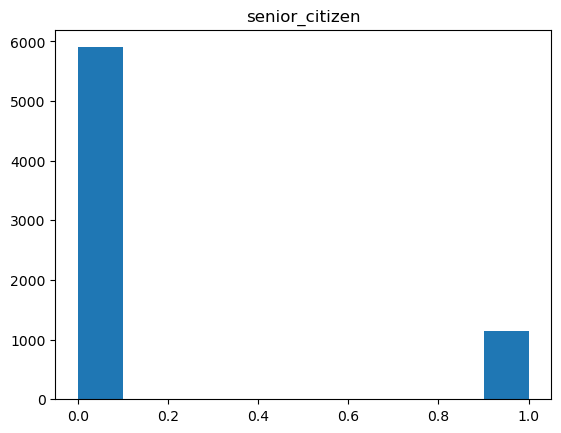

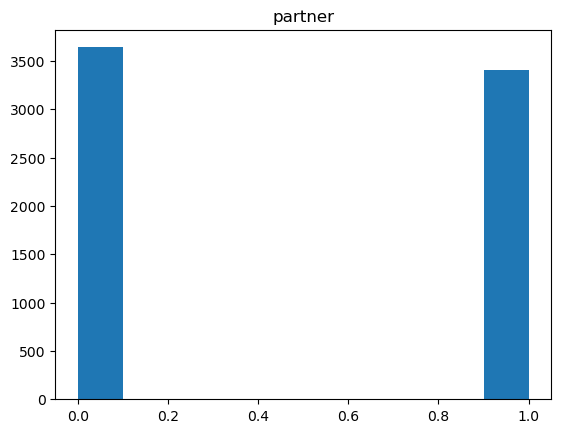

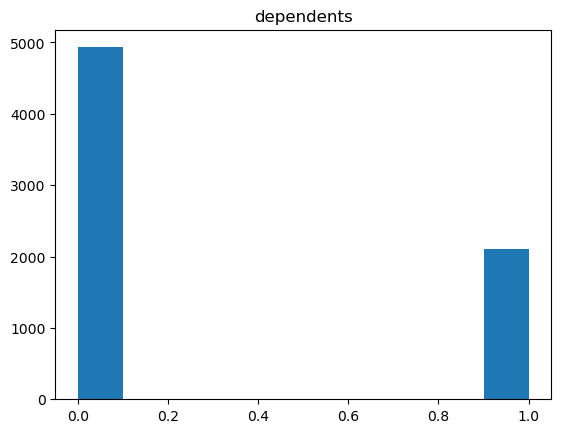

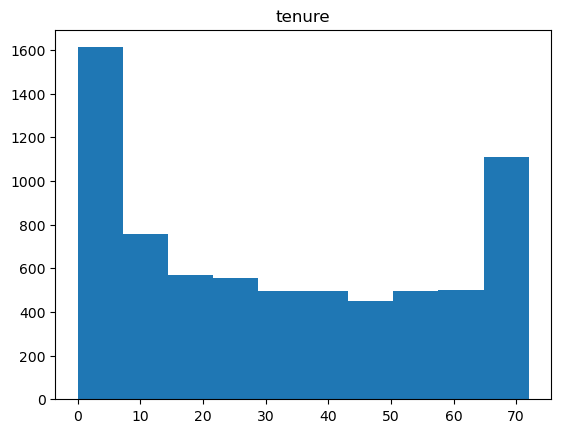

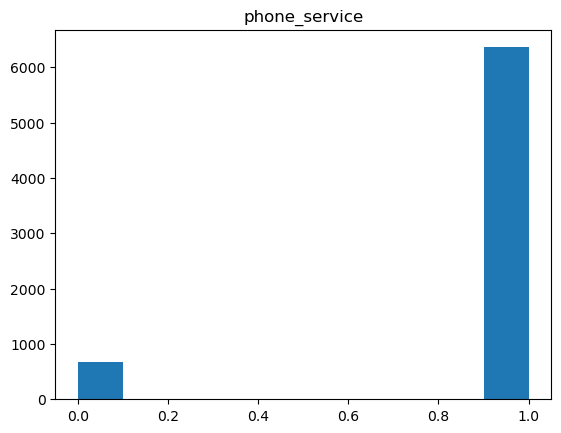

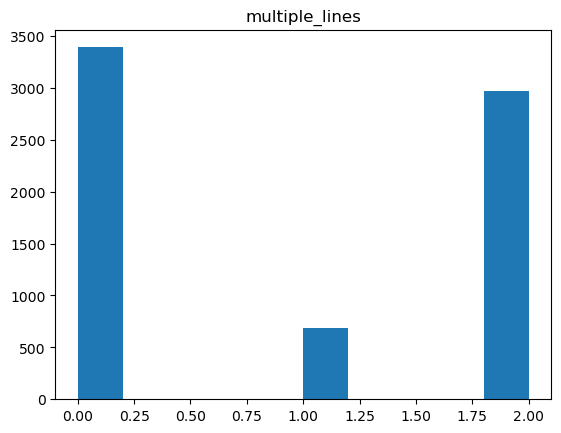

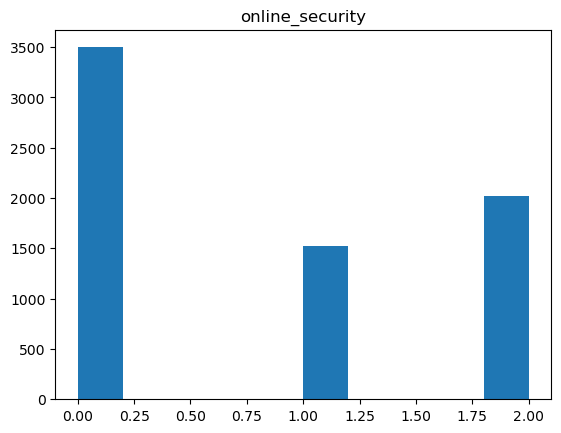

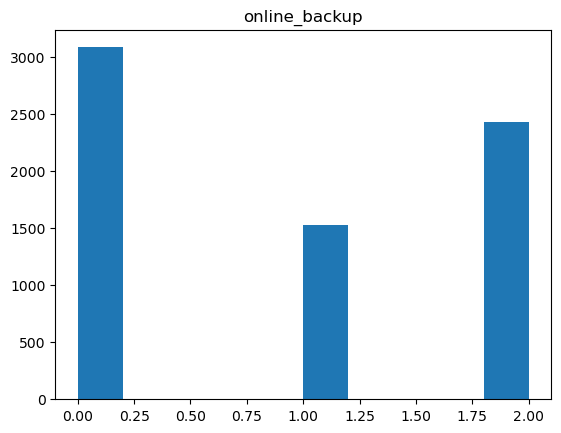

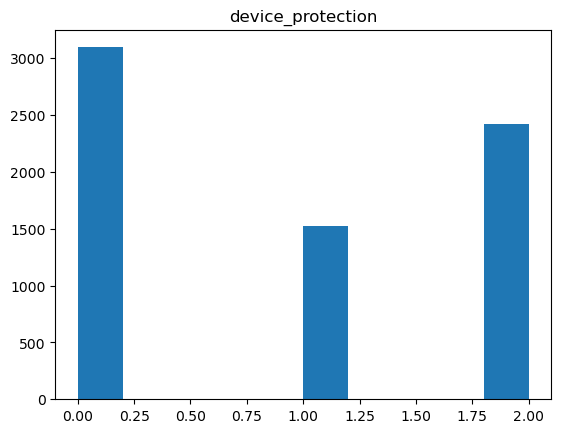

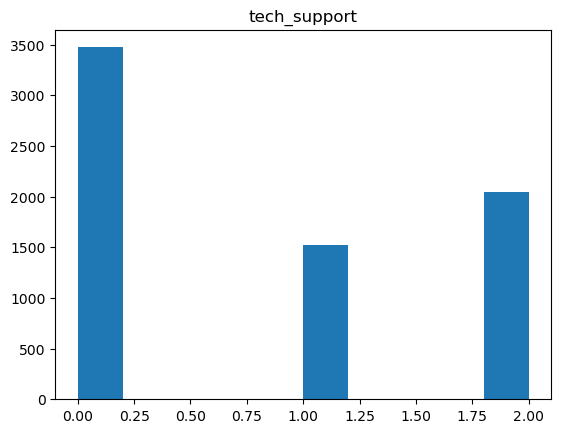

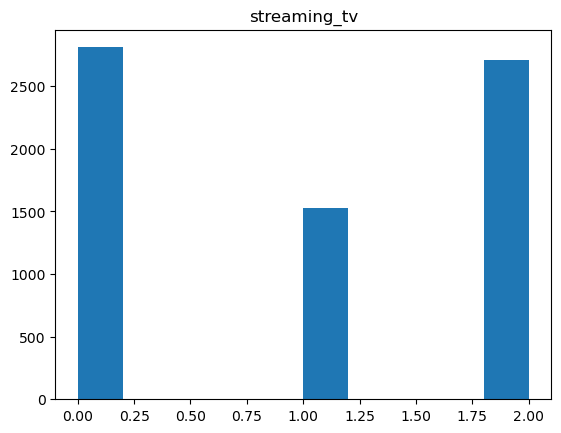

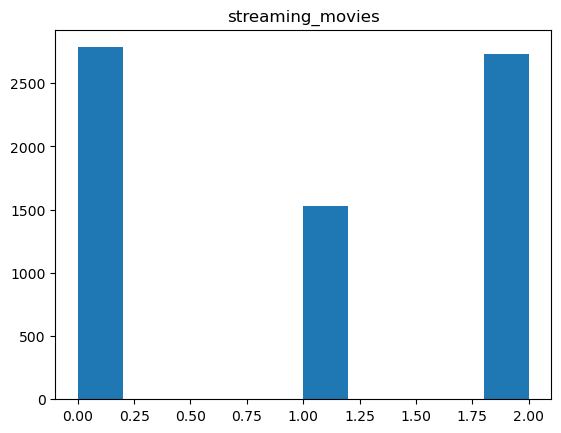

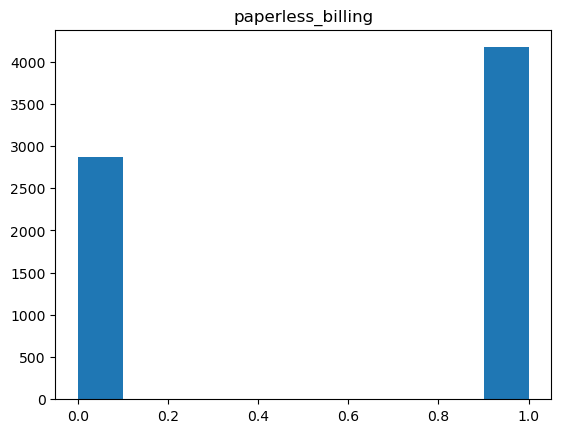

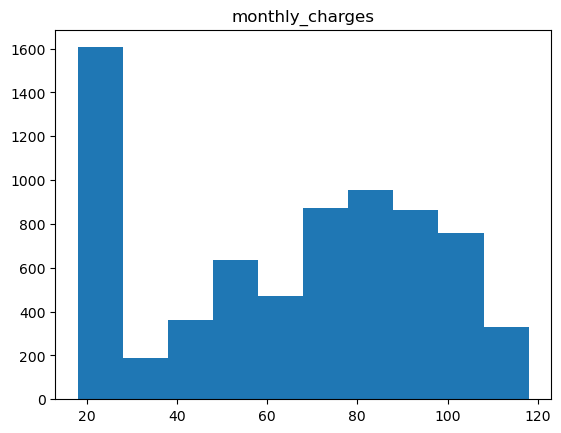

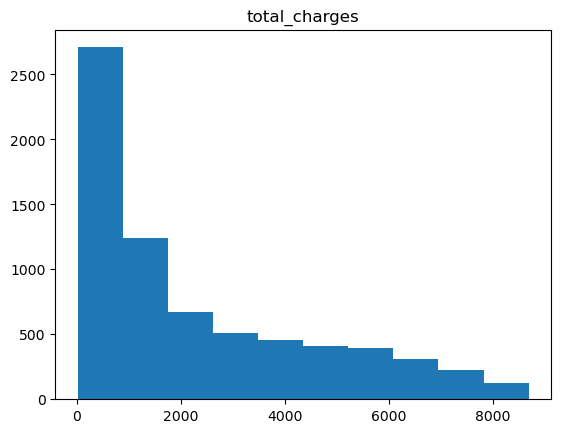

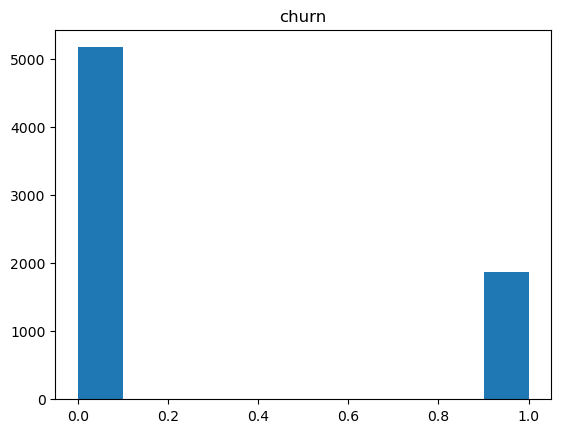

In [19]:
#get a full overview breakdown of you data in 
#charts to see where we could possibly deep dive 
#to indentify churn drivers 

for col in X:
    plt.hist(X[col])
    plt.title(col)
    plt.show()

In [20]:
#called train_validate_test_split(X,y, target='churn', seed=123

In [21]:
def telco_train_validate_test_split(X, target, seed=123):
    '''
    The functions takes a dataframe, target, and seed
    the target is for sorting and the seed splits the data into
    train, validate, and test. Test is 20% of the original data set
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train(56%), validate(24%), and test(20%).  
    Train, validate and test dataframes are returned in that order. 
    '''
    train_validate, test = train_test_split(X, test_size=0.2, 
                                            random_state=seed, 
                                            stratify=X[target])
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       random_state=seed,
                                       stratify=train_validate[target])
    return train, validate, test    

In [22]:
#sort the data with categorical variables
#we chose churn because we are looking for 
#what may contribute to churn.
train, validate, test = telco_train_validate_test_split(X, target='churn')

In [23]:
#got the shape of each dataset to verify 
#each set was separated according to the split
train.shape, validate.shape, test.shape

((3943, 20), (1691, 20), (1409, 20))

In [24]:
#verify you have even proportions of the target in each dataset
train.churn.mean(), validate.churn.mean(), test.churn.mean()

(0.2652802434694395, 0.26552335895919577, 0.2654364797728886)

## Data Exploration

## Does tenure affect churn? 
* Based on the graph we can see there is a 
  correlation between the number of months 
  a customer is with us and the likelyhood 
  of that customer leaving. 

## First impressions matter
* We can see that being able to keep a customer past
  the 18-19 month area means we've likely gained the 
  oppurtunity to make a long term customer. 

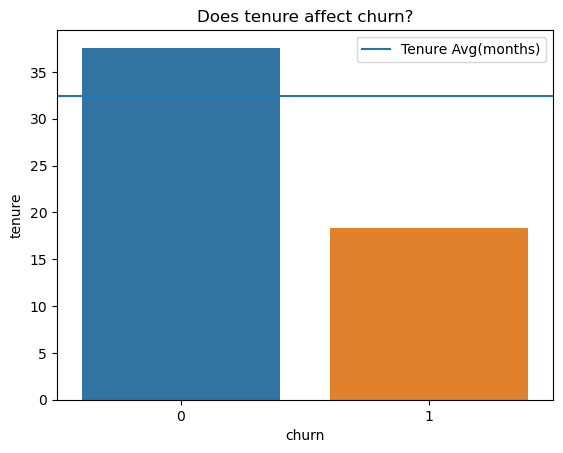

In [25]:
#plotted the affect of tenure on churn 
#to provide a view of the data
plt.title("Does tenure affect churn?")
sns.barplot(x="churn", y="tenure", data=train, ci=False)
avg_months_tenure = train.tenure.mean()
plt.axhline(avg_months_tenure, label="Tenure Avg(months)")
plt.legend()
plt.show()

In [26]:
#set two variables to separate the current customers
#from churned customers. 
churned = train[train.churn == 1]
not_churned = train[train.churn == 0]

## More supporting evidence
* The below graph dives deeper into 
  our tenure and churn questions 
  majority of our disconnects are coming
  within the first ten months of service 
  and we usually retain more customers that 
  stay with us past that mark. 

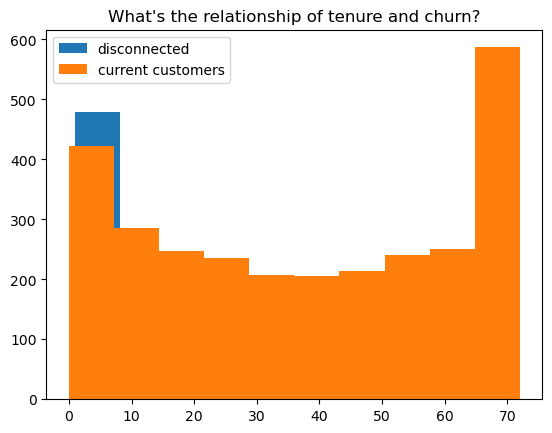

In [27]:
#set title
#plotted each variable in its own hist plot
#set the legend and plt.show() to illustrate the data. 

plt.title("What's the relationship of tenure and churn?")
plt.hist(churned.tenure, label="disconnected")
plt.hist(not_churned.tenure, label="current customers")
plt.legend()
plt.show()

## Diving deeper 
* A look into the crosstab data shows
* our oppurtunity area looks to be within the first six months
* of aquiring a customer. First impressions are important 
* we could take a look into why customers are leaving so fast especially 
* in the first month. Lowering that number makes an instant impact on our churn rate. 

In [28]:
#running a crosstab you can get a detailed view 
#of the tenure in months compared to churn or no churn. 
pd.crosstab(train.churn, train['tenure']).T


churn,0,1
tenure,,
0,8,0
1,121,212
2,60,72
3,56,49
4,54,44
5,32,29
6,45,19
7,47,33
8,43,21


## Statistical Testing
* I ran the chi-squared test to verify my findings and provide more evidence
  to support my analysis. p is the probability the variables are independent. 
  p < 0.05 is usually the test for dependence 
  If tenure does affect churn we can say they are dependant (p < alpha).
  If tenure does not affect churn we can say they are independent


In [29]:
#Lets run a chi squared to compare proportions, to have more confidence
#set variable alpha to 0.05
alpha = 0.05
#set null_hypothesis and alternative_hypothesis variables to a string
#to represent the possible results. 
null_hypothesis = "tenure and churn are independent "
alternative_hypothesis = "there is a relationship between churn and tenure"

#Setup a crosstab of observed churn to tenure
observed = pd.crosstab(train.churn, train['tenure'])

#The stats.chi2_contigency(observed) function does the heavy lifting here. It computes the 
#chi-square statistic and p-value for the hypothesis test of independence. Then passes the 
#values into the variables.
chi2, p, degf, expected = stats.chi2_contingency(observed)

#If statement to print the resultt. If p < alpha you get the first two statements
#If not you get the else statement. 
if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")
p


Reject the null hypothesis that tenure and churn are independent 
Sufficient evidence to move forward understanding that there is a relationship between churn and tenure


5.02386494439766e-89

## How does monthly charges affect churn?
* The data in the chart shows us that our current customers monthly charges 
  are just at sixty-dollars a month. Our churned customers monthly charges 
  are up to and above the monthly avg. There's a possible oppurtunity here to 
  lower our churn rate based on adjusting churn customers monthly pricing. 

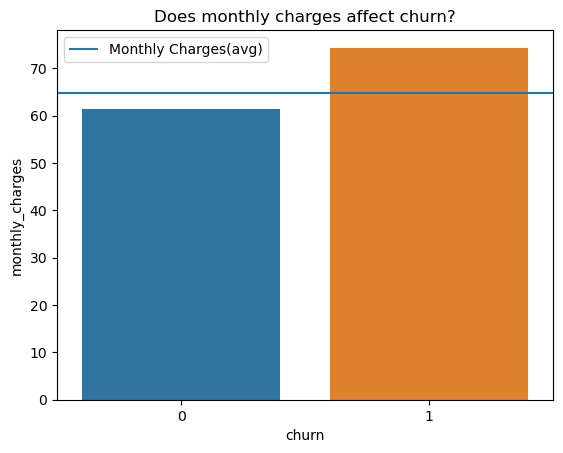

In [53]:
#plotted the affects of monthly charges on churn
#shows a view of how the data compares.
plt.title("Does monthly charges affect churn?")
sns.barplot(x="churn", y="monthly_charges", data=train, ci=False)
avg_monthly_charges = train.monthly_charges.mean()
plt.axhline(avg_monthly_charges, label="Monthly Charges(avg)")
plt.legend()
plt.show()

## Diving deeping into monthly charges
* The charts below illustrate where our current customers 
  monthly charges are and where our churn customers monthly
  charges are. There's a big difference in the number of 
  current customers paying twenty-thirty dollars compared to our
  churn group. We can also see once we get to about the seventy
  dollar range our churn spikes. It seems the twenty-thirty price range
  is keeping more of our customers.

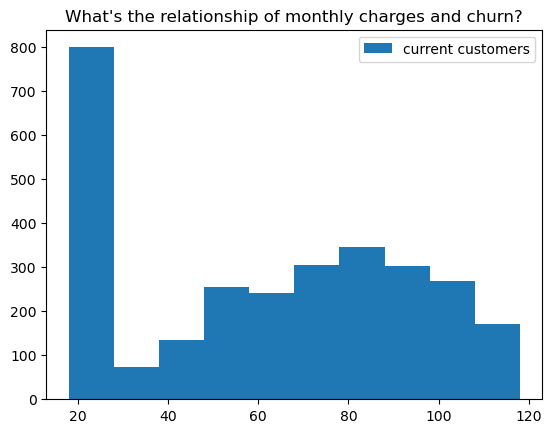

In [60]:
#plotted the relationship between not churned and monthly charges
plt.title("What's the relationship of monthly charges and churn?")
plt.hist(not_churned.monthly_charges, label="current customers")
plt.legend()
plt.show()

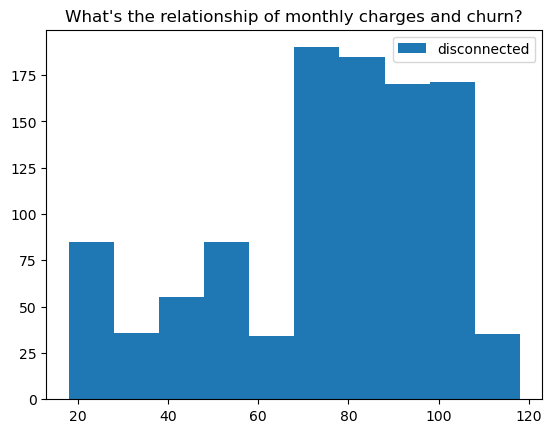

In [61]:
#plotted the discconects based on monthly charges
plt.title("What's the relationship of monthly charges and churn?")
plt.hist(churned.monthly_charges, label="disconnected")
#plt.hist(not_churned.monthly_charges, label="current customers")
plt.legend()
plt.show()

## Statistical Testing
* I ran the chi-squared test to verify my findings and provide more evidence
  to support my analysis. p is the probability the variables are independent. 
  p < 0.05 is usually the test for dependence 
  If tenure does affect churn we can say they are dependant (p < alpha).
  If tenure does not affect churn we can say they are independent

In [62]:
#Lets run a chi squared to compare proportions, to have more confidence
#set variable alpha to 0.05
alpha = 0.05
#set null_hypothesis and alternative_hypothesis variables to a string
#to represent the possible results. 
null_hypothesis = "monthly charges and churn are independent "
alternative_hypothesis = "there is a relationship between churn and monthly"

#Setup a crosstab of observed churn to tenure
observed = pd.crosstab(train.churn, train['monthly_charges'])

#The stats.chi2_contigency(observed) function does the heavy lifting here. It computes the 
#chi-square statistic and p-value for the hypothesis test of independence. Then passes the 
#values into the variables.
chi2, p, degf, expected = stats.chi2_contingency(observed)

#If statement to print the resultt. If p < alpha you get the first two statements
#If not you get the else statement. 
if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")
p


Reject the null hypothesis that monthly charges and churn are independent 
Sufficient evidence to move forward understanding that there is a relationship between churn and monthly


1.1014698390090695e-37

## Does total charges affect churn
* Reading into this specific chart alone you may not
  see the correlation but take into account the tenure
  of our current customers compared to our churned group
  our churned group has paid more than half the total charges
  (avg) when they are with the company for less than half the
  time of our current customers. Total charges play have a role 
  in charn. 
 
 ## Is there a total amount customers aren't willing to pay?
 * Considering majority of our churn happens within the first six months
   we could say churn customers arent willing to pay roughly fifteen hundred dollars
   in six months of service when our average tenure is thirty-two months and those
   customers on avg have only paid twenty-three hundred. Monthly charges go into
   total charges so there is similarity there. 

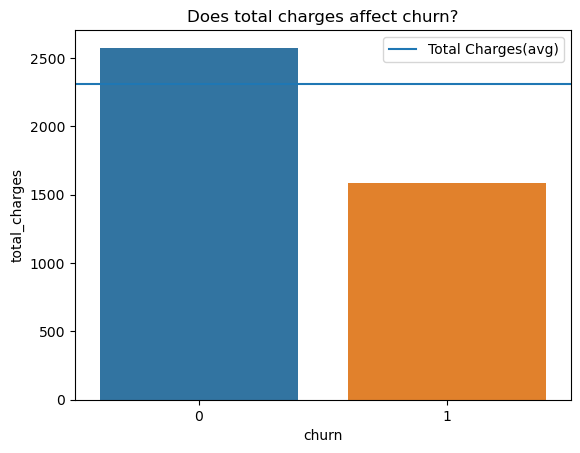

In [63]:
#plotted how churn and total charges correlate
plt.title("Does total charges affect churn?")
sns.barplot(x="churn", y="total_charges", data=train, ci=False)
avg_total_charges = train.total_charges.mean()
plt.axhline(avg_total_charges, label="Total Charges(avg)")
plt.legend()
plt.show()

## Does contract type affect churn
 * 1 = month-to-month
 * 2 = one-year
 * 3 = two-year
 
 * Our churn rate is highest in month-to-month customers, the longer the contract the lower the churn
   rate of our customers. There is a direct correlation, if we can get more customers into contracts 
   we can lower our churn rate. 

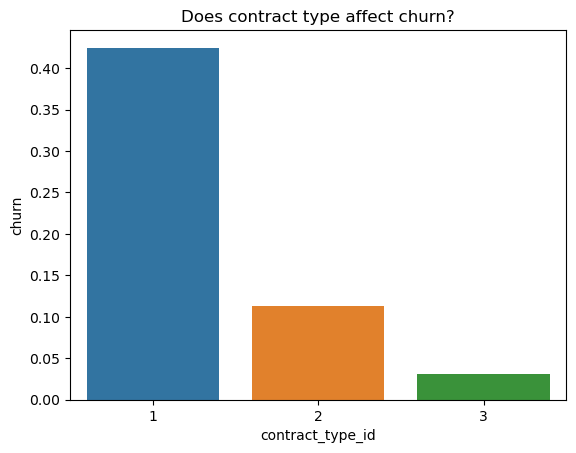

In [93]:
#plotted how churn and total contracts correlate
plt.title("Does contract type affect churn?")
sns.barplot(x="contract_type_id", y="churn", data=train, ci=False)
plt.show()

In [74]:
train.contract_type_id.value_counts()

1    2170
3     924
2     849
Name: contract_type_id, dtype: int64

## Exploration Summary
* tenure, monthly charges, total charges, and contract id type were found to be drivers of churn
* We could identify price points and tenure points that affected churn
* There is oppurtunity to lower our churn rate 

## Modeling
* accuracy will be my evaluation metric 
* not-churn 73.46% will be the baseline accuracy
* The best model will be tested against the test dataset

In [30]:
#select the target for our baseline. 
#no churn (0) is the higher value so we 
#will go with that
X.churn.value_counts()

0    5174
1    1869
Name: churn, dtype: int64

In [31]:
#set the baseline prediction for the dataset 
#based on the target
X['baseline_prediction'] = 0


In [32]:
#baseline accuracy calculated to get the baseline for 
#your target. 
baseline_accuracy = (X.baseline_prediction == X.churn).mean()
print(f'{baseline_accuracy:.2%}')

73.46%


In [33]:
#make train columns into a list 
#store the new list in X_cols variable
X_train = train.columns.to_list()

In [34]:
#churn from the features list
X_train.remove('churn')

In [35]:
#verify churn is removed
#X_train will be used in modeling
X_train

['payment_type_id',
 'internet_service_type_id',
 'contract_type_id',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'tenure',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'monthly_charges',
 'total_charges']

In [36]:
#assign churn to the y_train variable
#y_train will be used in modeling
y_train = 'churn'

In [37]:
#verify data in train X_train
train[X_train]

,payment_type_id,internet_service_type_id,contract_type_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges
5310,3,1,3,0,1,1,0,72,1,2,2,2,2,2,2,2,1,89,6697.35
3790,4,1,3,1,1,1,0,72,1,2,0,2,2,2,2,0,0,77,5396.25
4398,1,2,2,0,1,1,0,46,1,2,0,0,0,2,2,2,0,100,4753.85
2635,1,1,1,1,0,0,0,4,0,1,0,0,0,2,0,2,1,40,162.45
2986,2,1,1,1,0,1,0,8,1,0,0,2,2,0,0,0,1,54,445.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6230,1,2,3,1,0,1,1,72,1,2,0,2,2,0,2,2,1,103,7372.65
356,1,1,1,0,1,0,0,52,0,1,0,2,2,2,2,0,1,50,2566.30
2128,1,2,2,1,0,1,1,41,1,2,0,0,2,2,2,2,1,102,4213.35
3586,2,1,2,0,0,0,0,10,1,0,0,2,0,2,0,2,0,64,685.55


In [38]:
#verify data in train y_train
train[y_train]

5310    0
3790    0
4398    0
2635    0
2986    0
       ..
6230    1
356     0
2128    1
3586    0
6817    0
Name: churn, Length: 3943, dtype: int64

## Decision Tree 
* I've built decision trees to assist in evaluating our options, 
  I believe this structure will help us choose between different 
  paths that can address churn

* I used criterion='entropy' and variable max_depths to come up 
  with the best model. the algorithm calculates the entropy of each feature after every 
  split and selects the best feature and then splits by it. 
  entropy ranges from 0-1: low entropy means high information content because the 
  data is based around one value. High entropy is the opposite.

In [39]:
#created the first model as variable dt using the DecisionTreeClassifier()
#fit the model(measures how well a model genaralizes similar data to data on which it's trained)
#set the model predictions as model1_pred
#used the accuracy_score() funtion to get the models training accuracy.

dt = DecisionTreeClassifier(criterion='entropy',max_depth=5)
dt = dt.fit(train[X_train],train[y_train])
model1_pred = dt.predict(train[X_train])
accuracy = accuracy_score(train[y_train], model1_pred)
print(f'Training accuracy model 1: {round(accuracy*100,2)}%')

Training accuracy model 1: 79.99%


In [40]:
#created the second model. Following the same 
#criteria as the first model but changing the model variable and max_depth
#to identify model2

dt2 = DecisionTreeClassifier(criterion='entropy',max_depth=6)
dt2 = dt2.fit(train[X_train],train[y_train])
model2_pred = dt2.predict(train[X_train])
accuracy = accuracy_score(train[y_train], model2_pred)
print(f'Training accuracy model 2: {round(accuracy*100,2)}%')

Training accuracy model 2: 81.31%


In [41]:
#created the third model. Following the same 
#criteria as the first model but changing the model variable and max_depth
#to identify model3
dt3 = DecisionTreeClassifier(criterion='entropy',max_depth=7)
dt3 = dt3.fit(train[X_train],train[y_train])
model3_pred = dt3.predict(train[X_train])
accuracy = accuracy_score(train[y_train], model3_pred)
print(f'Training accuracy model 3: {round(accuracy*100,2)}%')

Training accuracy model 3: 82.3%


In [42]:
#created the fourth model. Following the same 
#criteria but changing the model variable and max_depth
#to identify model4
dt4 = DecisionTreeClassifier(criterion='entropy', max_depth=8)
dt4 = dt4.fit(train[X_train],train[y_train])
model4_pred = dt4.predict(train[X_train])
accuracy = accuracy_score(train[y_train], model4_pred)
print(f'Training accuracy model 4: {round(accuracy*100,2)}%')

Training accuracy model 4: 83.59%


In [43]:
#created the 5th model. Following the same 
#criteria but changing the model variable and max_depth
#to identify model5
dt5 = DecisionTreeClassifier(criterion='entropy')
dt5 = dt5.fit(train[X_train],train[y_train])
model5_pred = dt5.predict(train[X_train])
accuracy = accuracy_score(train[y_train], model5_pred)
print(f'Training accuracy model 5: {round(accuracy*100,2)}%')

Training accuracy model 5: 99.85%


In [44]:
#printed out each accuracy score for each model. 
print(f'Training accuracy model 1: {accuracy_score(train[y_train], model1_pred):.2%}')
print(f'Training accuracy model 2: {accuracy_score(train[y_train], model2_pred):.2%}')
print(f'Training accuracy model 3: {accuracy_score(train[y_train], model3_pred):.2%}')
print(f'Training accuracy model 4: {accuracy_score(train[y_train], model4_pred):.2%}')
print(f'Training accuracy model 5: {accuracy_score(train[y_train], model5_pred):.2%}')

Training accuracy model 1: 79.99%
Training accuracy model 2: 81.31%
Training accuracy model 3: 82.30%
Training accuracy model 4: 83.59%
Training accuracy model 5: 99.85%


## Model Evaluation
* After finding the accuracy score of the models. I've tested each below to verify 
  which performs best on the validate data. 

In [45]:
#created variables for validate dataset X_val, and y_val
#holds the features and target
X_val, y_val, = validate[X_train], validate[y_train]

In [46]:
#printed the training accuracy and validate accuracy scores
#to see how each model did against the validate dataset. 

print(f'Training accuracy model 1: {accuracy_score(train[y_train], model1_pred):.2%}')
print(f'Validate accuracy model 1: {dt.score(X_val, y_val):.2%}')

print(f'Training accuracy model 2: {accuracy_score(train[y_train], model2_pred):.2%}')
print(f'Validate accuracy model 2: {dt2.score(X_val, y_val):.2%}')

print(f'Training accuracy model 3: {accuracy_score(train[y_train], model3_pred):.2%}')
print(f'Validate accuracy model 3: {dt3.score(X_val, y_val):.2%}')

print(f'Training accuracy model 4: {accuracy_score(train[y_train], model4_pred):.2%}')
print(f'Validate accuracy model 4: {dt4.score(X_val, y_val):.2%}')

print(f'Training accuracy model 5: {accuracy_score(train[y_train], model5_pred):.2%}')
print(f'Validate accuracy model 5: {dt5.score(X_val, y_val):.2%}')

print(f'Baseline accuracy {baseline_accuracy:.2%}')

Training accuracy model 1: 79.99%
Validate accuracy model 1: 81.02%
Training accuracy model 2: 81.31%
Validate accuracy model 2: 78.59%
Training accuracy model 3: 82.30%
Validate accuracy model 3: 79.66%
Training accuracy model 4: 83.59%
Validate accuracy model 4: 78.36%
Training accuracy model 5: 99.85%
Validate accuracy model 5: 73.51%
Baseline accuracy 73.46%


In [47]:
#printed the difference in train and validate scores for each model
#selected the lowest difference model
print(f'Model 1 Train/Val difference: {dt.score(X_val, y_val) - accuracy_score(train[y_train], model1_pred):.2%}')
print(f'Model 2 Train/Val difference: {dt2.score(X_val, y_val) - accuracy_score(train[y_train], model2_pred):.2%}')
print(f'Model 3 Train/Val difference: {dt3.score(X_val, y_val) - accuracy_score(train[y_train], model3_pred):.2%}')
print(f'Model 4 Train/Val difference: {dt4.score(X_val, y_val) - accuracy_score(train[y_train], model4_pred):.2%}')
print(f'Model 5 Train/Val difference: {dt5.score(X_val, y_val) - accuracy_score(train[y_train], model5_pred):.2%}')

Model 1 Train/Val difference: 1.03%
Model 2 Train/Val difference: -2.72%
Model 3 Train/Val difference: -2.64%
Model 4 Train/Val difference: -5.24%
Model 5 Train/Val difference: -26.34%


## Selecting the best model
* Model one had the highest validate accuracy score when compared to the train dataset and the lowest
  difference in train/validate score. Based on that, it will be used to validate against the test dataset. 

In [48]:
#best model verified against test dataset. 
X_test, y_test = test[X_train], test[y_train]

In [69]:
#printed out the training, validate, and test accuracy for the best model
print(f'Model 1 training accuracy: {accuracy_score(train[y_train], model1_pred):.2%}')
print(f'Model 1 validate accuracy: {dt.score(X_val, y_val):.2%}')
print(f'Model 1 test accuracy: {dt.score(X_test, y_test):.2%}')
print(f'Baseline accuracy {baseline_accuracy:.2%}')

Model 1 training accuracy: 79.99%
Model 1 validate accuracy: 81.02%
Model 1 test accuracy: 78.71%
Baseline accuracy 73.46%


# Decision Tree nodes
* The decision tree breakdown shows probability of customers staying or leaving. 
  The brown/brownish nodes show factors that are helping us retrain customers 
  and the blue/blueish nodes are factors that play a roll in customer churn.
  Using the flow and breakdown of the chart we can work on ideas to put more of our
  customers in the stay nodes rather than the leave nodes. 

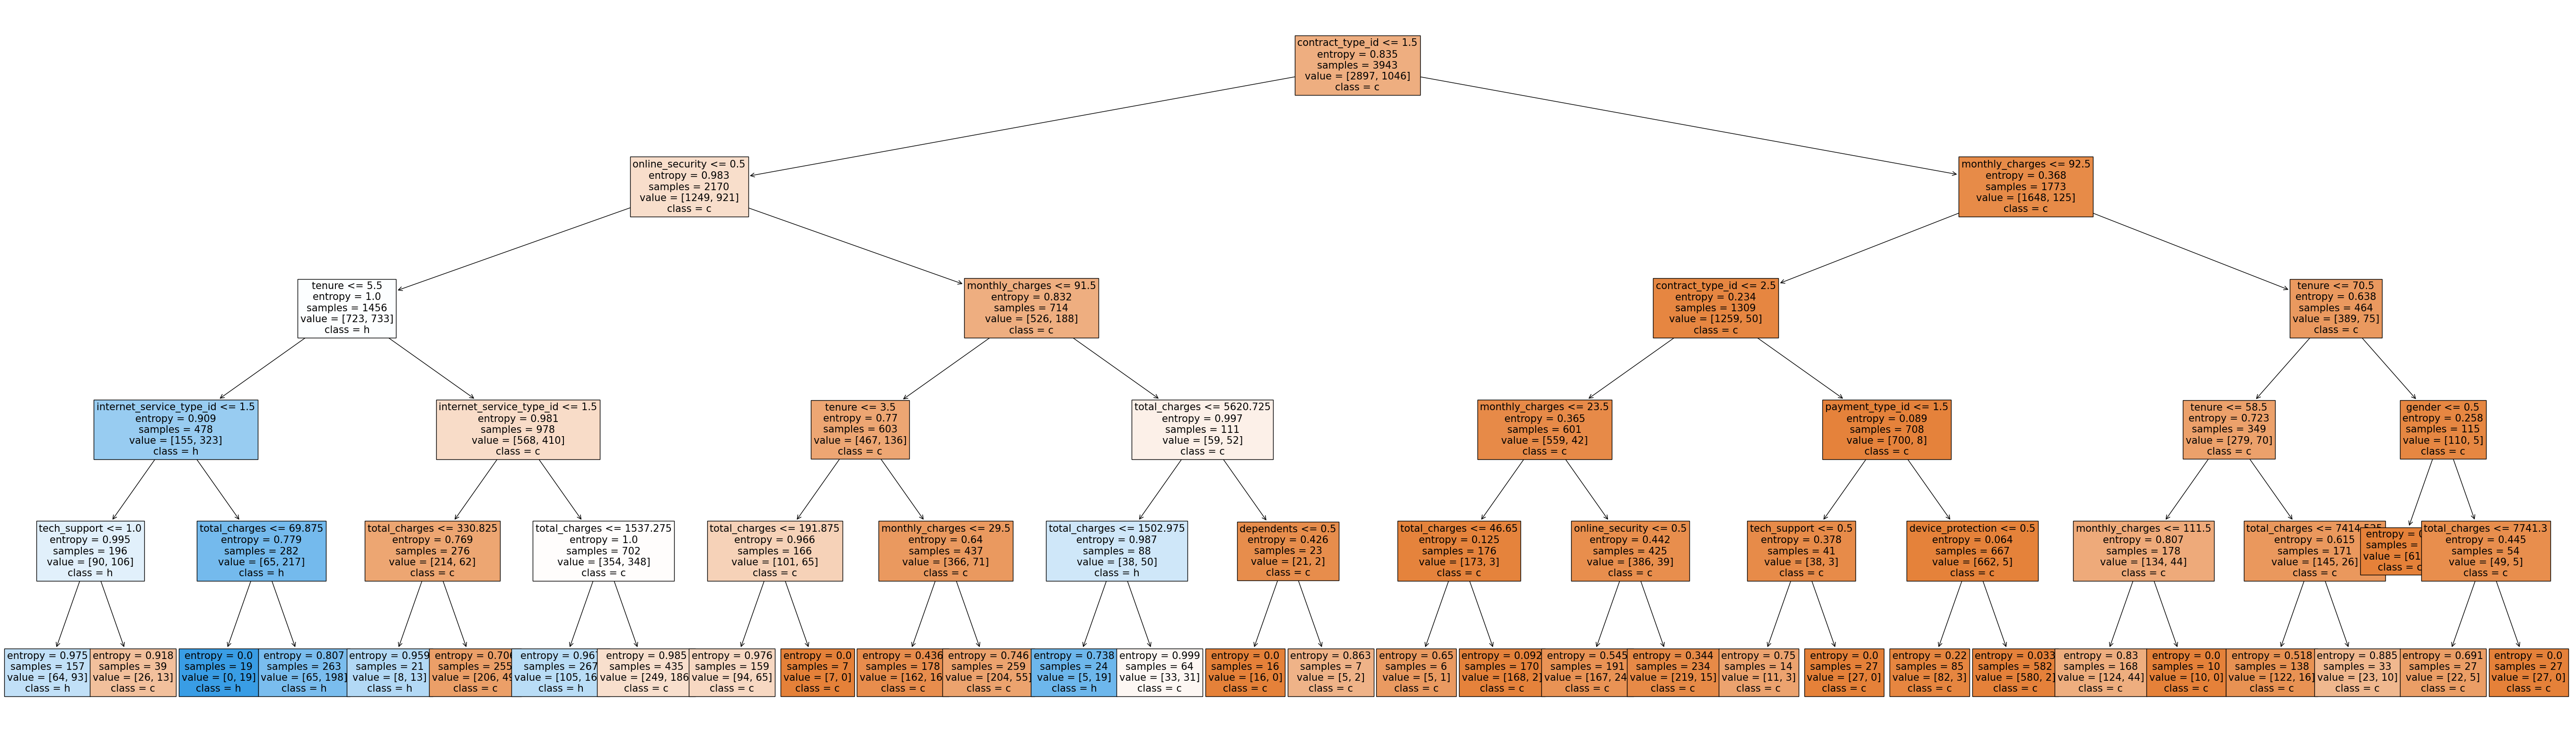

In [50]:
#plotted the decision tree to show the model
#set my feature names as fn 
#set target as cn
#set filled - True gives the nodes color
#figsize and fontsize will can be set to give you the 
#best view. 

fn=X_train
cn=y_train
fig, axe = plt.subplots(figsize=(70,20))
plot_tree(dt,feature_names = fn, class_names=cn, filled = True, fontsize=15);

## Conclusion

### Exploration Proved
 * tenure, monthly charges, total charges, and contract id type were found to be drivers of churn
 * We could identify price points and tenure points that affected churn
 * There is oppurtunity to lower our churn rate 
 
### Modeling 
 * The best model outperformed the baseline 
 * The decision tree breakdown shows our areas of strength this is keeping customers
 * The breakdown also lays out oppurtunity areas to lower our churn rate

## Recommendations 
 * In order to lower the churn rate I would focus on aligning churn customers charges and services with our  more tenured customers.

## Next Steps
 * Set a six month tenure limit and rerun the sample to go into whats specifics are different in the customer who churn before six months and those who stay pass six months. 